In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder

In [2]:
dataset_path = '/content/drive/MyDrive/DriveApp/CNNProject/data/'

In [3]:
# Defining the transformation functions which will be applied while loading the dataset
from torchvision import transforms
transform_functions = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

In [4]:
# Loading the dataset
data = ImageFolder(root=dataset_path,transform=transform_functions)
class_labels = data.classes

In [5]:
class_labels

['CNV', 'DME', 'Drusen', 'Normal']

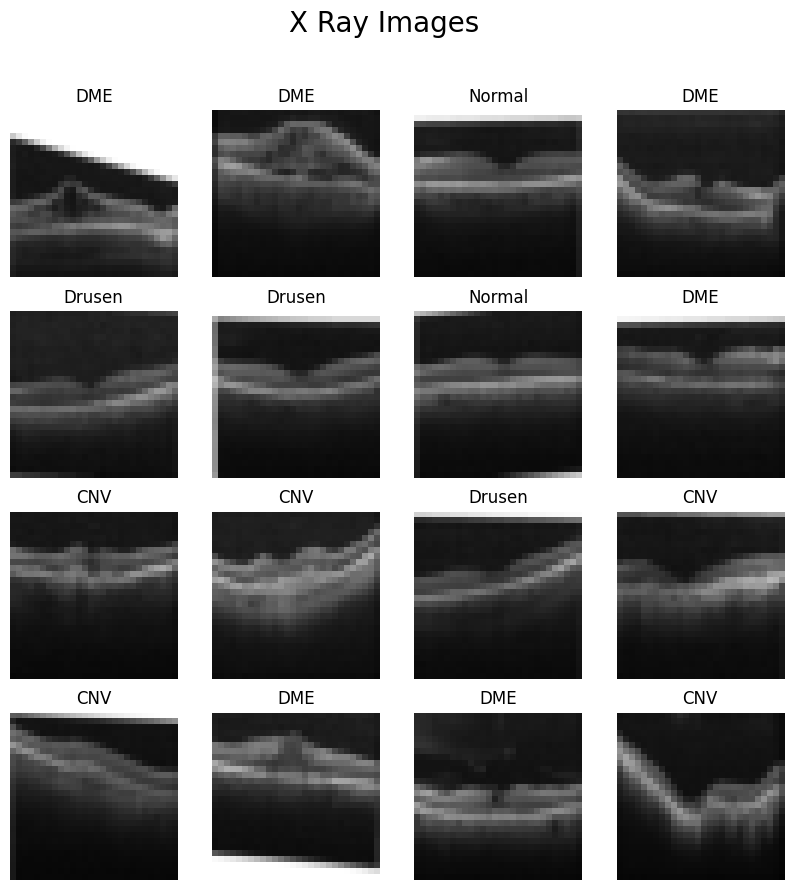

In [ ]:
# Displaying some random images
import matplotlib.pyplot as plt
import random
fig,axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle('X Ray Images',fontsize=20)

random_indices = list(random.sample(range(len(data)),16))

for i in range(4):
  for j in range(4):
    img,label = data[random_indices[4*i+j]]
    axes[i,j].imshow(img.permute(1,2,0),interpolation = 'none')
    axes[i,j].axis('off')
    axes[i,j].set_title(class_labels[label])


In [ ]:
# Splitting the dataset into training and tesing data
from torch.utils.data import random_split
train_size = int(0.8*len(data))
test_size = len(data) - train_size

train_dataset,test_dataset = random_split(data,[train_size,test_size])

In [ ]:
# Dividing the training and testing dataset into batches
from torch.utils.data import DataLoader
training_batches = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True,num_workers=2)
testing_batches = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=2)

In [ ]:
# Defining the architecture of our network
class MyNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extraction = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(32*7*7,32),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(32,16),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(16,4)
    )

  def forward(self,x):
    out = self.feature_extraction(x)
    out = self.classifier(out)
    return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = MyNetwork().to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

epochs = 50

In [ ]:
for i in range(epochs):
  total = 0
  correct = 0

  for batch_images,batch_labels in training_batches:
    optimizer.zero_grad()

    batch_images = batch_images.to(device)
    batch_labels = batch_labels.to(device)

    output = model(batch_images)
    loss = loss_function(output,batch_labels)

    loss.backward()
    optimizer.step()

    output_labels = torch.max(output,dim=1)[1]

    total = total + batch_labels.shape[0]
    correct = correct + (output_labels == batch_labels).sum().item()

  print(f"Epoch : {i+1}, Accuracy : {correct/total}")

Epoch : 1, Accuracy : 0.3111969111969112
Epoch : 2, Accuracy : 0.421003861003861
Epoch : 3, Accuracy : 0.4450965250965251
Epoch : 4, Accuracy : 0.45343629343629344
Epoch : 5, Accuracy : 0.4744401544401544
Epoch : 6, Accuracy : 0.47057915057915056
Epoch : 7, Accuracy : 0.4796911196911197
Epoch : 8, Accuracy : 0.48725868725868726
Epoch : 9, Accuracy : 0.5000772200772201
Epoch : 10, Accuracy : 0.5051737451737451
Epoch : 11, Accuracy : 0.5233976833976834
Epoch : 12, Accuracy : 0.5213899613899614
Epoch : 13, Accuracy : 0.5295752895752895
Epoch : 14, Accuracy : 0.5183011583011583
Epoch : 15, Accuracy : 0.5227799227799228
Epoch : 16, Accuracy : 0.5275675675675676
Epoch : 17, Accuracy : 0.5291119691119691
Epoch : 18, Accuracy : 0.5417760617760617
Epoch : 19, Accuracy : 0.54996138996139
Epoch : 20, Accuracy : 0.5451737451737452
Epoch : 21, Accuracy : 0.5528957528957529
Epoch : 22, Accuracy : 0.5491891891891892
Epoch : 23, Accuracy : 0.5538223938223938
Epoch : 24, Accuracy : 0.5621621621621622
E

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/DriveApp/CNNProject/model_weights28.pth')

In [ ]:
model.eval()

MyNetwork(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [ ]:
with torch.no_grad():
  total = 0
  correct = 0

  for batch_images,batch_labels in testing_batches:

    batch_images = batch_images.to(device)
    batch_labels = batch_labels.to(device)

    output = model(batch_images)
    output_labels = torch.max(output,dim=1)[1]

    total = total + batch_labels.shape[0]
    correct = correct + (output_labels == batch_labels).sum().item()

  print(f"Testing Accuracy : {correct/total}")

Testing Accuracy : 0.6436071649166152
